## importing needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner import RandomSearch
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report
from tensorflow.keras.applications import MobileNetV2
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from keras.applications import EfficientNetB0
from glob import glob

## Loading and Labeling Skin Lesion Images from CSV and Director

In [2]:
import pandas as pd
import os
from glob import glob

# Base directory containing the image folders
base_skin_dir = os.path.join(os.path.expanduser('~'), 'Downloads')

# Merging images from both folders into one dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# Dictionary for human-friendly labels
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


# Load the CSV file
csv_path = '/Users/hrithik/Downloads/HAM10000_metadata.csv'
df = pd.read_csv(csv_path)

# Initialize lists to store image paths and labels
image_paths = []
labels = []

# Iterate over the rows of the CSV file and fill the lists
for index, row in df.iterrows():
    image_id = row['image_id']
    label = row['dx']
    
    if image_id in imageid_path_dict:
        image_paths.append(imageid_path_dict[image_id])
        labels.append(lesion_type_dict[label])

# Create a DataFrame with image paths and labels
data = {'image_path': image_paths, 'labels': labels}
image_df = pd.DataFrame(data)
image_df.sample(10)


image_path  \
8668  /Users/hrithik/Downloads/HAM10000_images_part_...   
8946  /Users/hrithik/Downloads/HAM10000_images_part_...   
5295  /Users/hrithik/Downloads/HAM10000_images_part_...   
7739  /Users/hrithik/Downloads/HAM10000_images_part_...   
5242  /Users/hrithik/Downloads/HAM10000_images_part_...   
6642  /Users/hrithik/Downloads/HAM10000_images_part_...   
5392  /Users/hrithik/Downloads/HAM10000_images_part_...   
702   /Users/hrithik/Downloads/HAM10000_images_part_...   
9532  /Users/hrithik/Downloads/HAM10000_images_part_...   
9141  /Users/hrithik/Downloads/HAM10000_images_part_...   

                              labels  
8668                Melanocytic nevi  
8946                Melanocytic nevi  
5295                Melanocytic nevi  
7739                Melanocytic nevi  
5242                Melanocytic nevi  
6642                Melanocytic nevi  
5392                Melanocytic nevi  
702   Benign keratosis-like lesions   
9532                Melanocytic nevi  
9141                Melanocytic nevi

## Displaying Random Samples of Skin Lesion Images with Labels

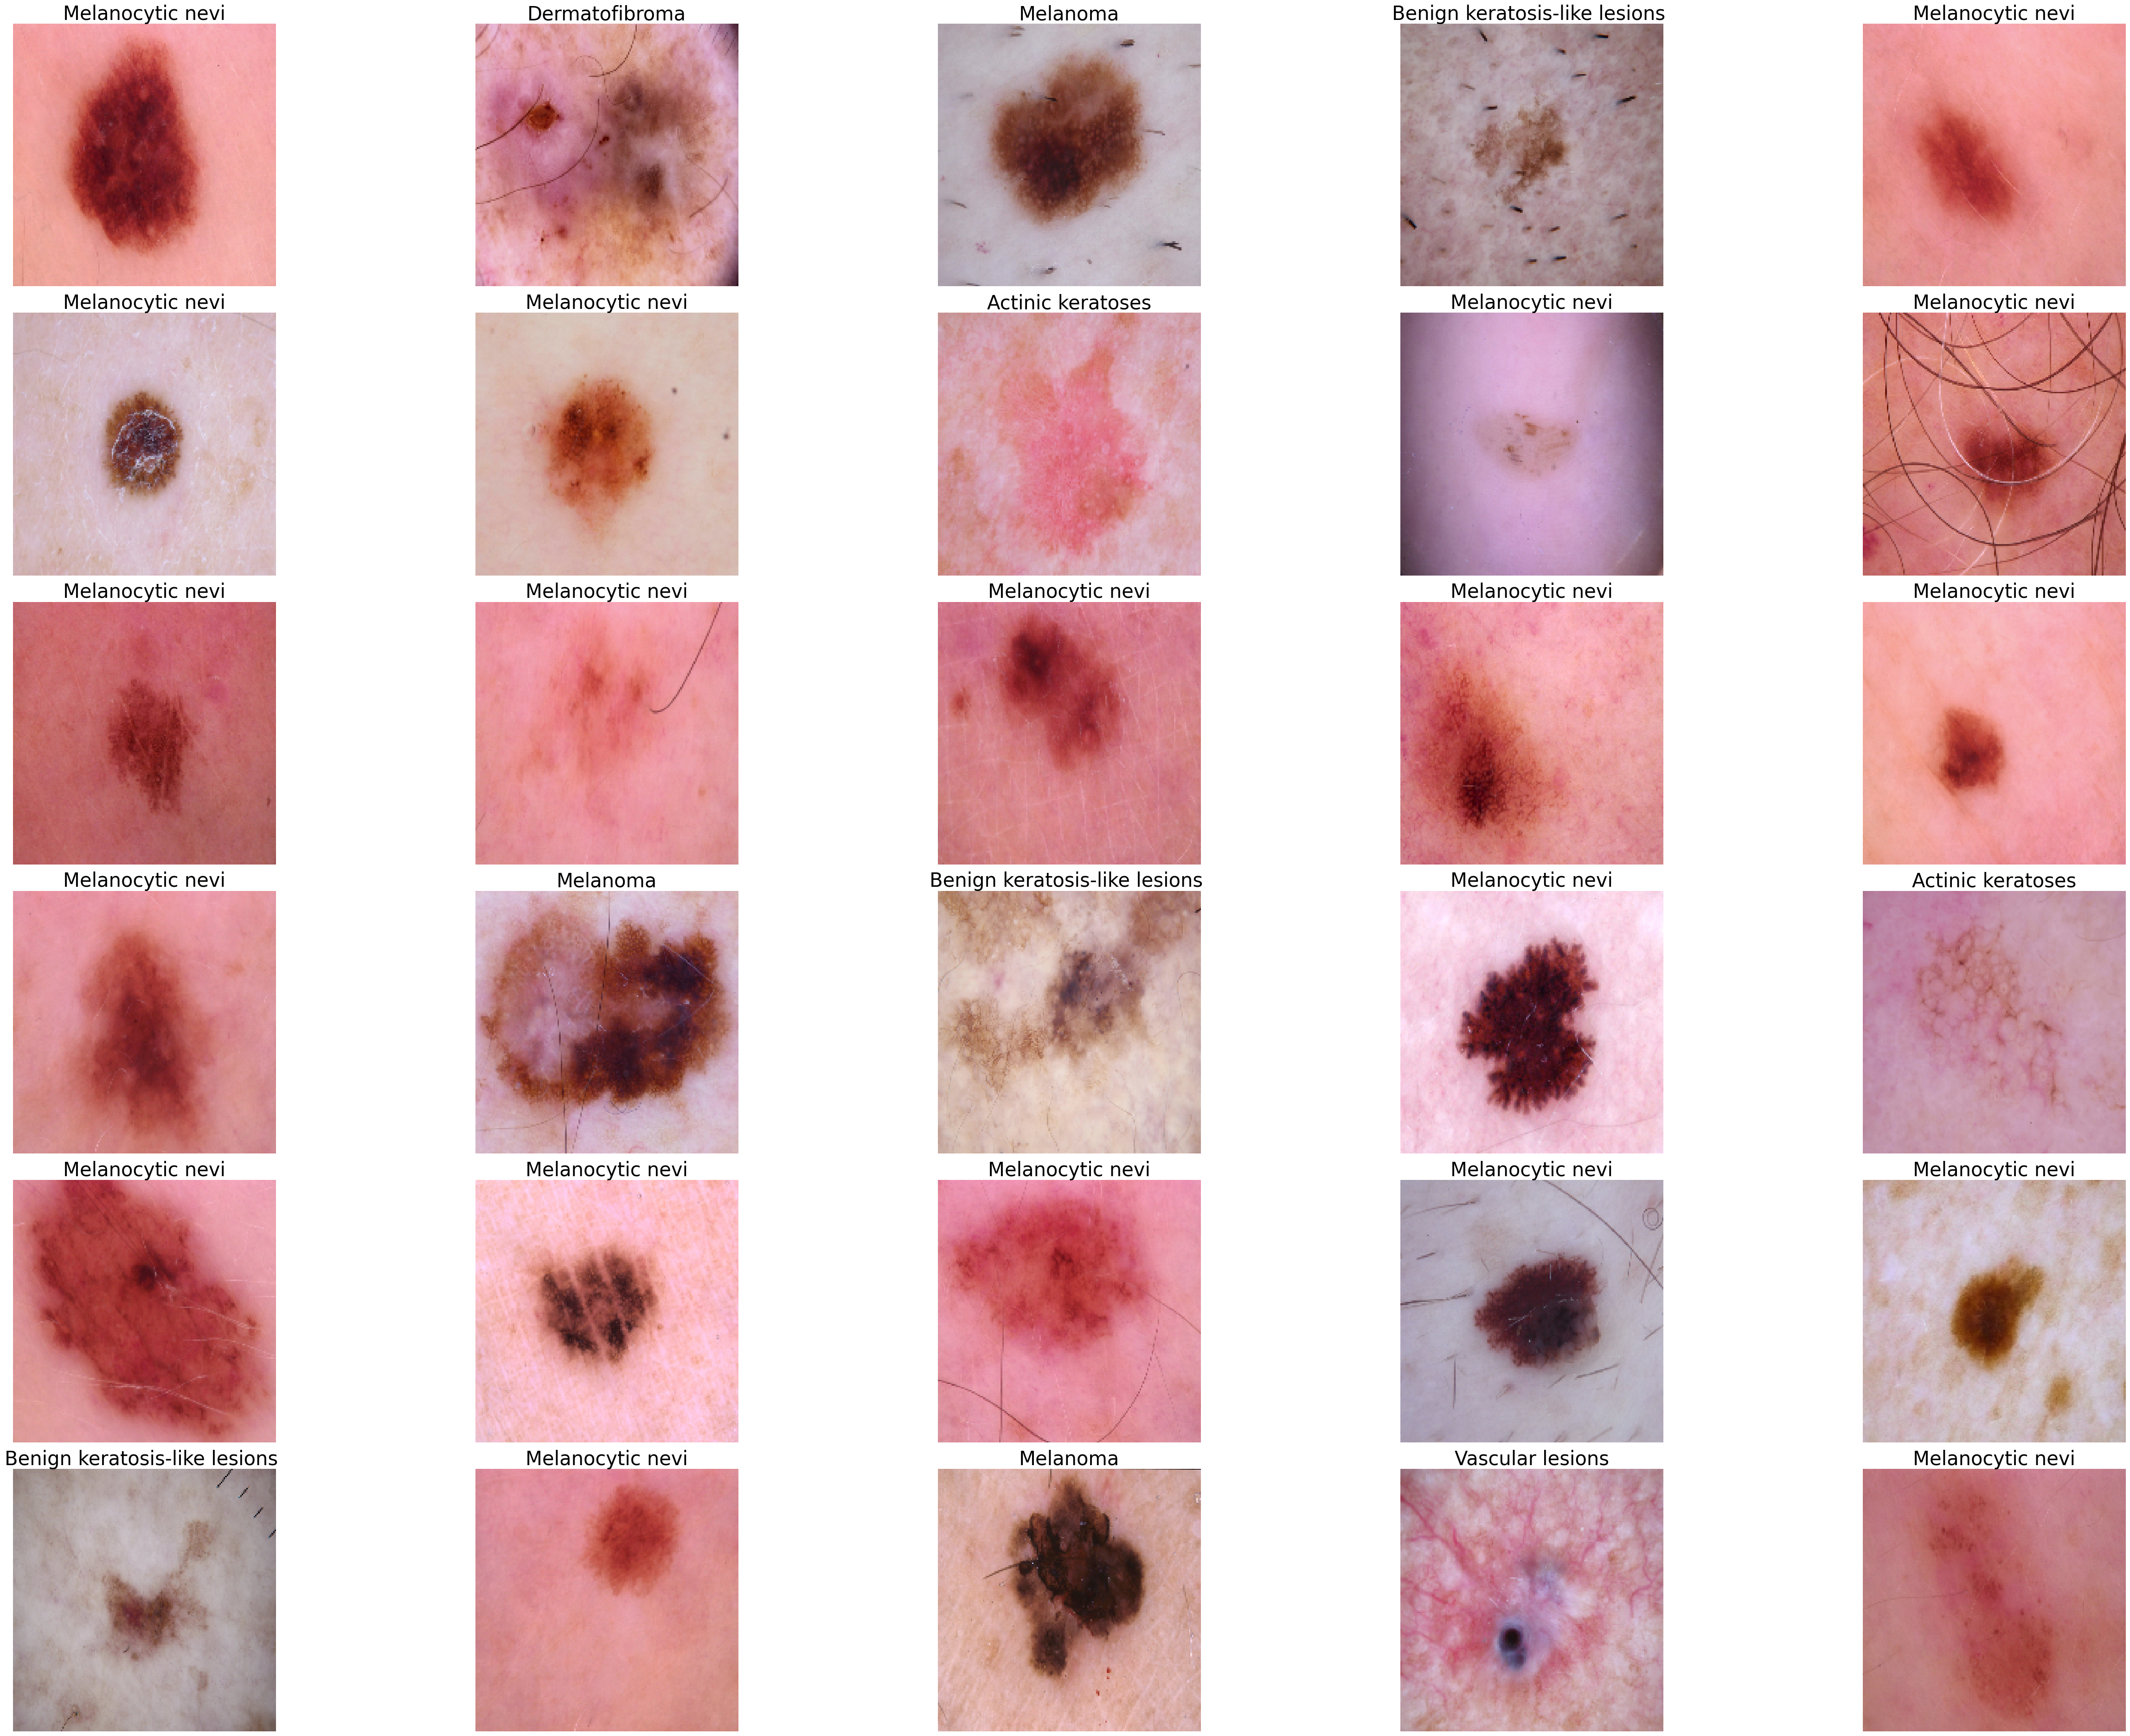

In [3]:
plt.figure(figsize=(50, 50))
random_indices = np.random.randint(0, len(image_df), 30)
for idx, i in enumerate(random_indices):
    plt.subplot(8, 5, idx + 1)
    img = cv2.imread(image_df['image_path'][i])
    img = cv2.resize(img, (176, 176))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(image_df['labels'][i], fontsize=30)
plt.tight_layout()
plt.show()

## Visualization of Class Distribution in Skin Lesion Dataset

/var/folders/rc/22ngdkp17cj38q4nyj84wwx40000gn/T/ipykernel_29207/1292853745.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=image_df['labels'], palette='bright',legend=False)


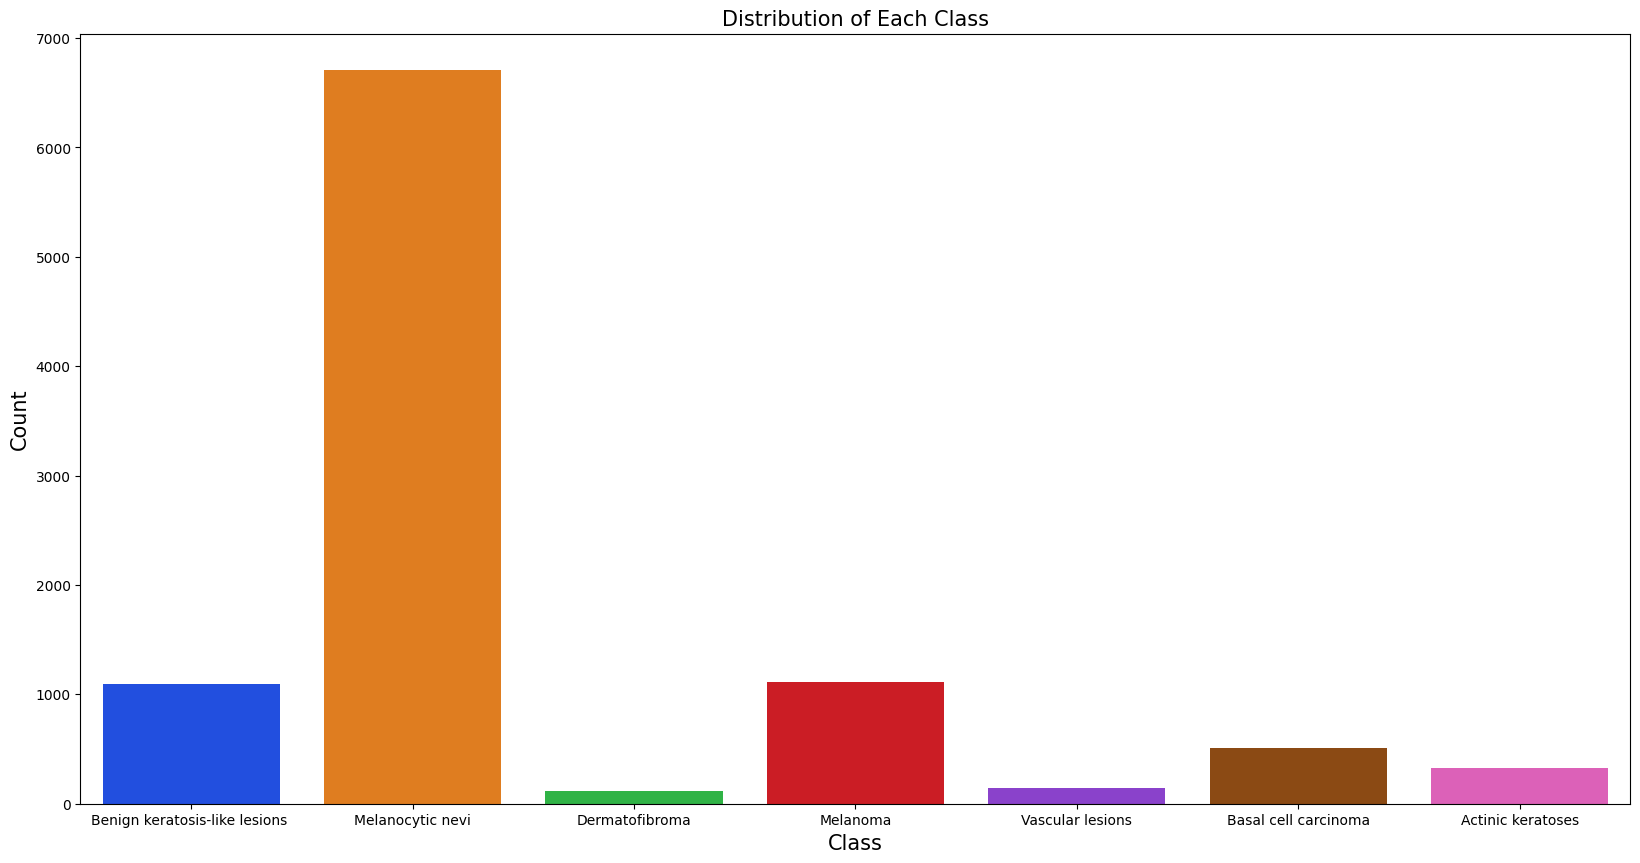

In [4]:
plt.figure(figsize=(20, 10))
ax = sns.countplot(x=image_df['labels'], palette='bright',legend=False)
ax.set_xlabel("Class", fontsize=15)
ax.set_ylabel("Count", fontsize=15)
plt.title('Distribution of Each Class', fontsize=15)
plt.show()

## Downsampling the Dataset by Sampling and Combining 'Melanocytic Nevi' with Other Classes

In [5]:
# Filter 'Melanocytic nevi' rows
melanocytic_nevi_df = image_df[image_df['labels'] == 'Melanocytic nevi']
# Randomly sample 2000 rows
melanocytic_nevi_sampled = melanocytic_nevi_df.sample(n=4100, random_state=42)

# Combine the sampled 'Melanocytic nevi' with the rest of the data
remaining_df = image_df[image_df['labels'] != 'Melanocytic nevi']
balanced_df = pd.concat([melanocytic_nevi_sampled, remaining_df])

## Class Distribution After downsampling the Dataset Balancing

/var/folders/rc/22ngdkp17cj38q4nyj84wwx40000gn/T/ipykernel_29207/802792908.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=balanced_df['labels'], palette='bright',legend=False)


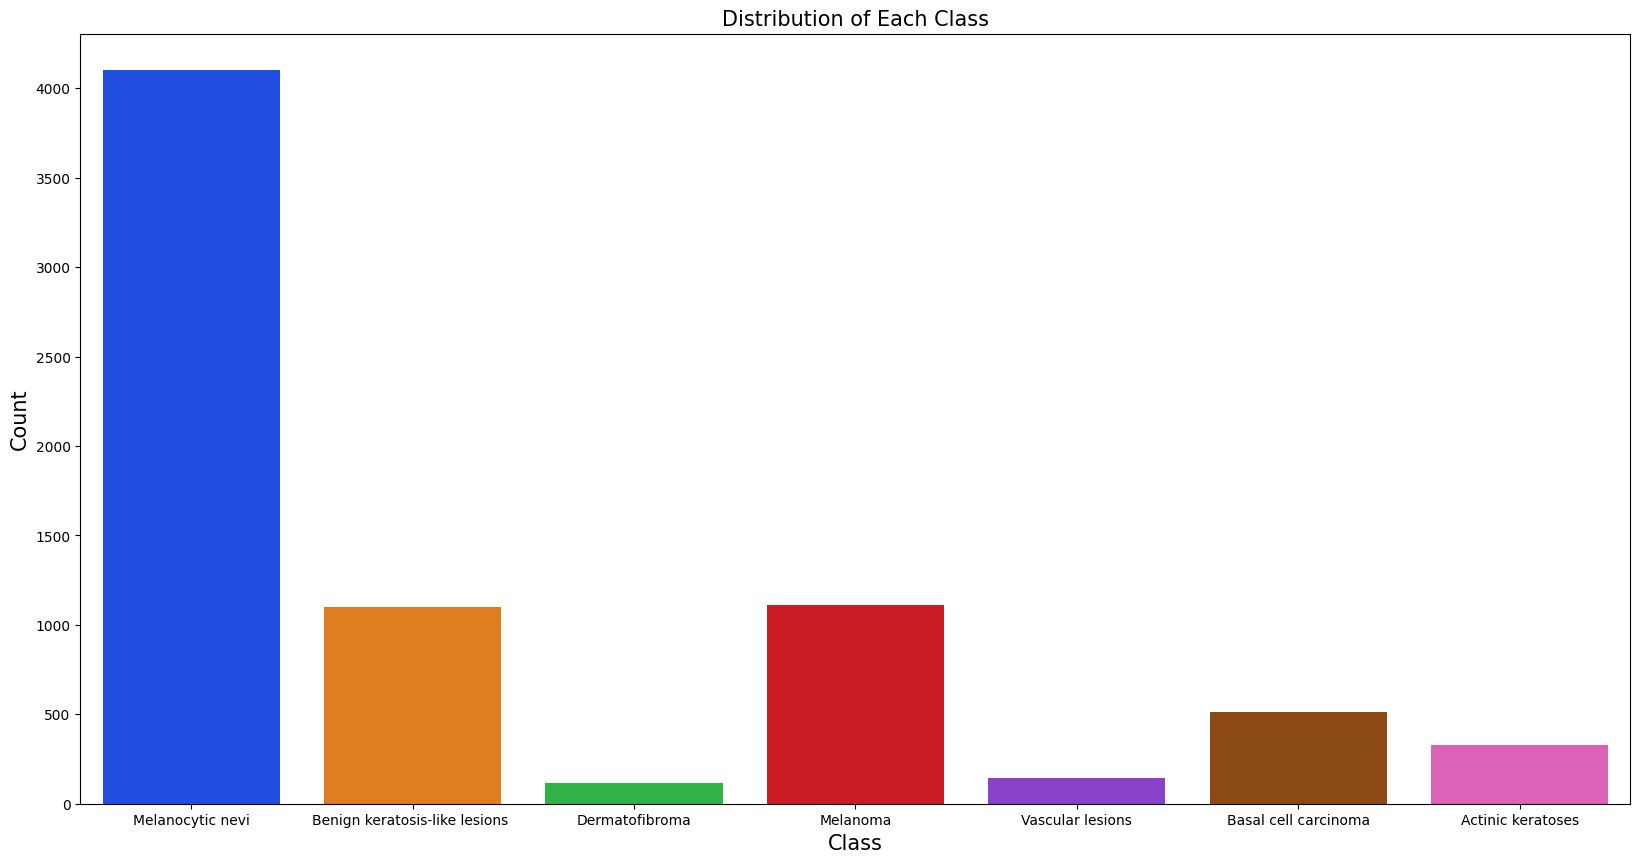

In [6]:
plt.figure(figsize=(20, 10))
ax = sns.countplot(x=balanced_df['labels'], palette='bright',legend=False)
ax.set_xlabel("Class", fontsize=15)
ax.set_ylabel("Count", fontsize=15)
plt.title('Distribution of Each Class', fontsize=15)
plt.show()

## Preparing Training Data by Generating and Aggregating Batches from DataFrame

In [7]:
# Create an ImageDataGenerator instance with rescaling
img_da_gen = ImageDataGenerator(rescale=1./255)

# Generate training data from dataframe
train_data_gen = img_da_gen.flow_from_dataframe(
    balanced_df, 
    x_col='image_path', 
    y_col='labels', 
    target_size=(176, 176), 
    batch_size=1000, 
    shuffle=False
)

# Initialize lists to store images and labels
images, labels = [], []

# Retrieve data and labels from the generator
for batch_data, batch_labels in train_data_gen:
    images.append(batch_data)
    labels.append(batch_labels)
    if len(images) >= len(train_data_gen):
        break

# Combine all batches into single arrays
train_data = np.vstack(images)
train_labels = np.concatenate(labels)


Found 7410 validated image filenames belonging to 7 classes.


## Splitting and Displaying Shapes of Training, Validation, and Test Sets

In [8]:
# Split the data into training and remaining sets
X_train, X_temp, y_train, y_temp = train_test_split(
    train_data, train_labels, test_size=0.3, random_state=42, shuffle=True, stratify=train_labels
)

# Further split the remaining data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=42, shuffle=True, stratify=y_temp
)

# Display the shapes of the resulting datasets
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'y_val shape: {y_val.shape}')


X_train shape: (5187, 176, 176, 3)
X_test shape: (667, 176, 176, 3)
X_val shape: (1556, 176, 176, 3)
y_train shape: (5187, 7)
y_test shape: (667, 7)
y_val shape: (1556, 7)


## Model 1 CNN Training 

In [9]:
#layers of the CNN
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32,kernel_size=(3,3),strides=2,padding='same',activation='relu',input_shape=(176,176,3)))
model.add(keras.layers.Conv2D(64,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024,activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(7,activation='softmax'))
model.summary()
#Train model
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train,y_train, epochs=11, validation_data=(X_val,y_val))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 88, 88, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    31,720,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,747,015 (121.11 MB)

 Trainable params: 31,747,015 (121.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/11
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 127ms/step - accuracy: 0.5327 - loss: 1.3844 - val_accuracy: 0.5559 - val_loss: 1.1621
Epoch 2/11
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step - accuracy: 0.5984 - loss: 1.0417 - val_accuracy: 0.6125 - val_loss: 1.0854
Epoch 3/11
163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - accuracy: 0.6309 - loss: 0.9529 - val_accuracy: 0.6407 - val_loss: 0.9753
Epoch 4/11
163/163 ━━━━━━━━━━━━━━━━━━━━ 18s 113ms/step - accuracy: 0.6554 - loss: 0.8805 - val_accuracy: 0.6401 - val_loss: 0.9494
Epoch 5/11
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.6843 - loss: 0.8351 - val_accuracy: 0.6060 - val_loss: 1.1337
Epoch 6/11
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.6988 - loss: 0.7866 - val_accuracy: 0.6767 - val_loss: 0.8662
Epoch 7/11
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.7314 - loss: 0.6931 - val_accuracy: 0.6812 - val_loss: 0.8856
Epoch 8/11
163/163 ━━━━━━━━━━━━━━━━━━━━ 17s 107ms/step - accuracy: 0.7454 - loss: 0

## Evaluation of model 1 

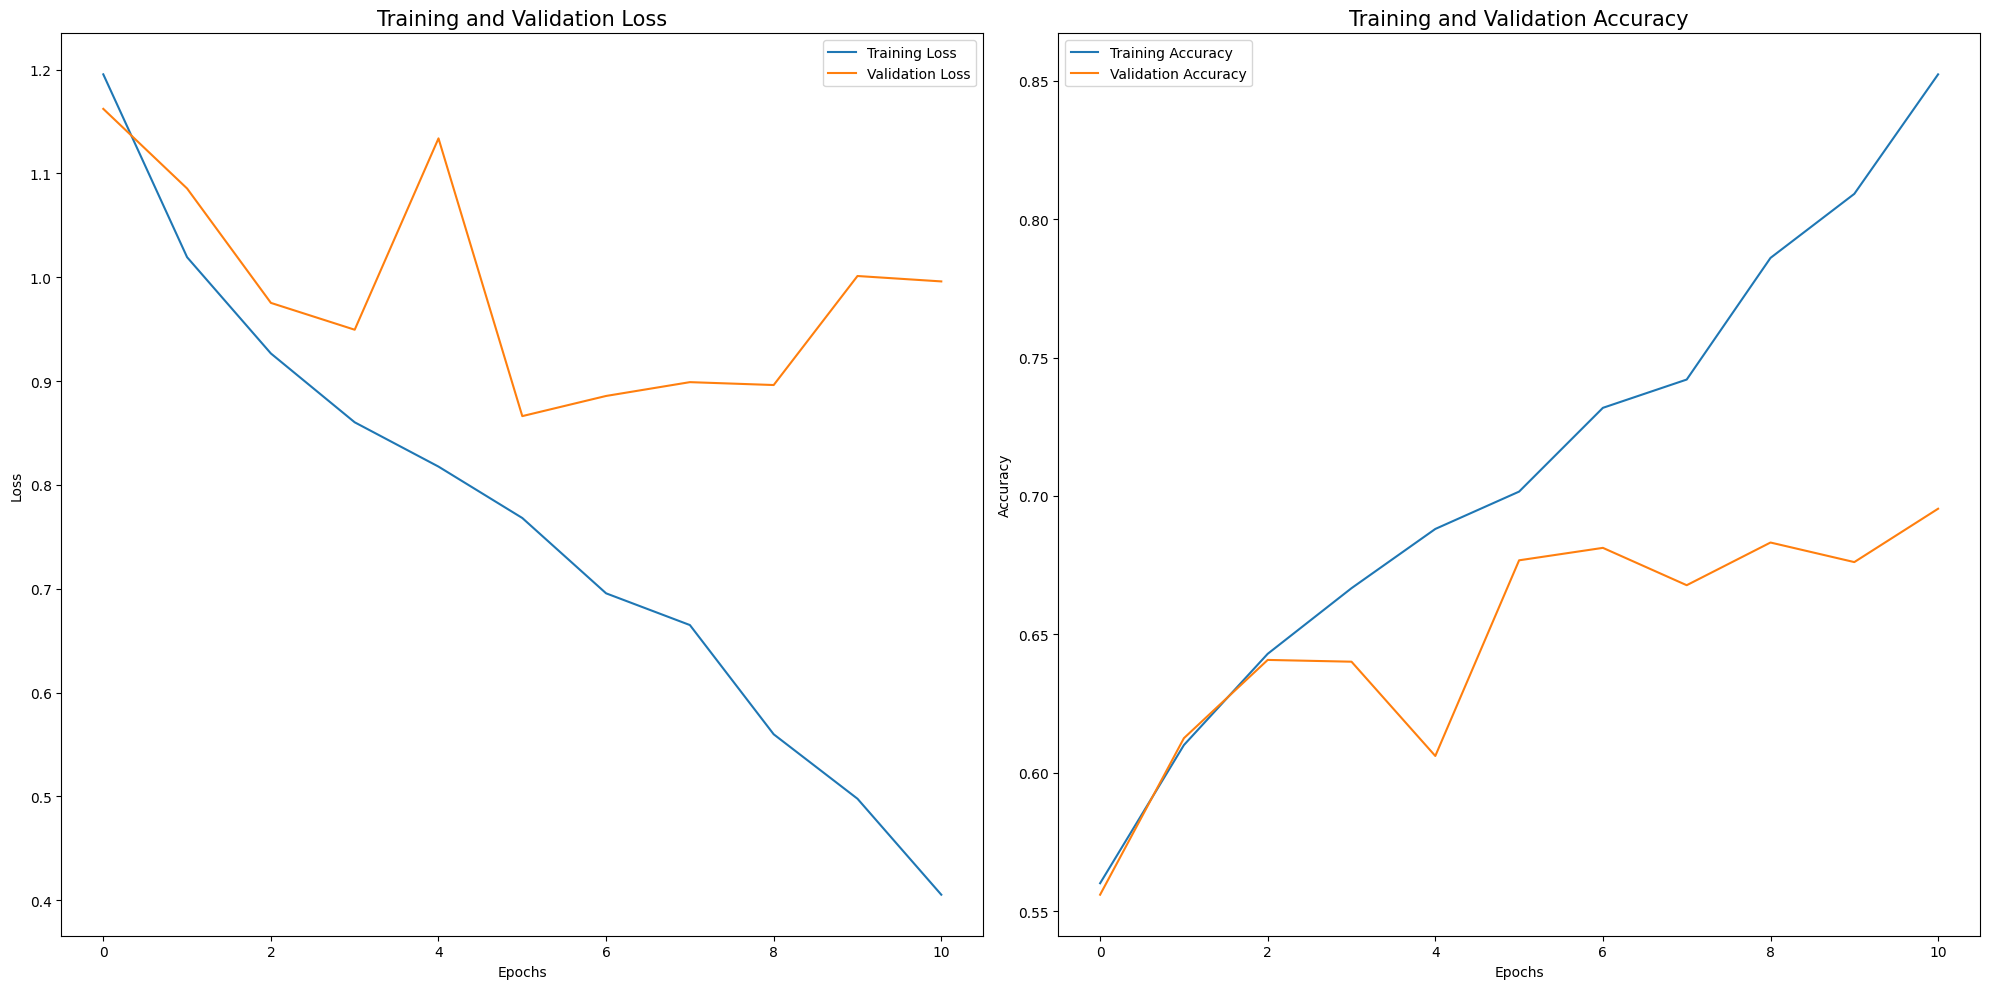

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
    accuracy      loss  val_accuracy  val_loss
0   0.560054  1.195342      0.555913  1.162111
1   0.609986  1.019245      0.612468  1.085418
2   0.642954  0.926563      0.640746  0.975270
3   0.666667  0.860286      0.640103  0.949428
4   0.688066  0.817620      0.606041  1.133695
5   0.701562  0.768131      0.676735  0.866238
6   0.731830  0.695590      0.681234  0.885649
7   0.742047  0.665040      0.667738  0.898947
8   0.786003  0.559857      0.683162  0.896175
9   0.809138  0.497786      0.676093  1.001153
10  0.852323  0.405376      0.695373  0.995949
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6531 - loss: 0.9618
Test Accuracy = 0.6626686453819275
Classification Report
              precision    recall  f1-score   support

           0       0.50      0.07      0.12        30
           1       0.35      0.78      0.48        46
           2       0.53      0.41      0.47        99
           3       0.12      0.10      0.11     

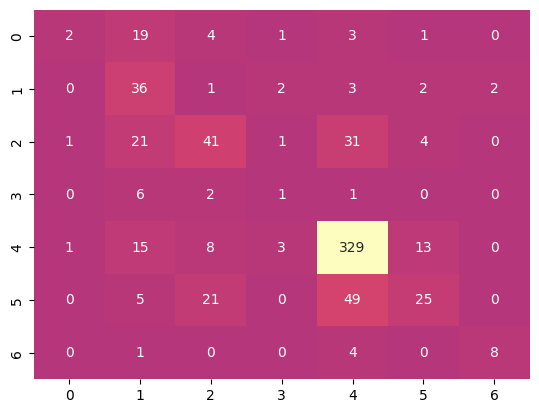

In [11]:
history=pd.DataFrame(hist.history)
# Create figure for training and validation loss and accuracy
plt.figure(figsize=(20, 10))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=15)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=15)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

#prediction test data
predictions = model.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)

#confusion matrix
CM = confusion_matrix(y_test_,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='magma')

print(history)

# test loss and test accuracy
a,b= model.evaluate(X_test,y_test)
print('Test Accuracy =', b)


#classification report
ClassificationReport = classification_report(y_test_,y_pred)
print("Classification Report")
print(ClassificationReport)


## Model 2 CNN(Custom) Training 

In [13]:
#layers of the CNN
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32,kernel_size=(3,3),strides=2,padding='same',activation='relu',input_shape=(176,176,3)))
model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'))
model.add(keras.layers.Conv2D(64,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.MaxPool2D(pool_size=(2,2),strides=2,padding='same'))
model.add(keras.layers.Conv2D(128,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.Conv2D(256,kernel_size=(3,3),strides=2,activation='relu',padding='same'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(1024,activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(7,activation='softmax'))
model.summary()
#Train model
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(X_train,y_train, epochs=11, validation_data=(X_val,y_val))

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 88, 88, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 44, 44, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 22, 22, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 11, 11, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 3, 3, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │     2,360,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,755,911 (10.51 MB)

 Trainable params: 2,755,911 (10.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/11
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.5574 - loss: 1.3190 - val_accuracy: 0.5829 - val_loss: 1.1760
Epoch 2/11
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 43ms/step - accuracy: 0.5706 - loss: 1.1618 - val_accuracy: 0.5771 - val_loss: 1.2036
Epoch 3/11
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6040 - loss: 1.0789 - val_accuracy: 0.6067 - val_loss: 1.0522
Epoch 4/11
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6205 - loss: 1.0177 - val_accuracy: 0.6118 - val_loss: 1.0213
Epoch 5/11
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6199 - loss: 1.0016 - val_accuracy: 0.6208 - val_loss: 0.9890
Epoch 6/11
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6446 - loss: 0.9411 - val_accuracy: 0.6433 - val_loss: 0.9444
Epoch 7/11
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6651 - loss: 0.8718 - val_accuracy: 0.6414 - val_loss: 0.9391
Epoch 8/11
163/163 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6808 - loss: 0.8379 - val_accu

## Evaluation of model 2

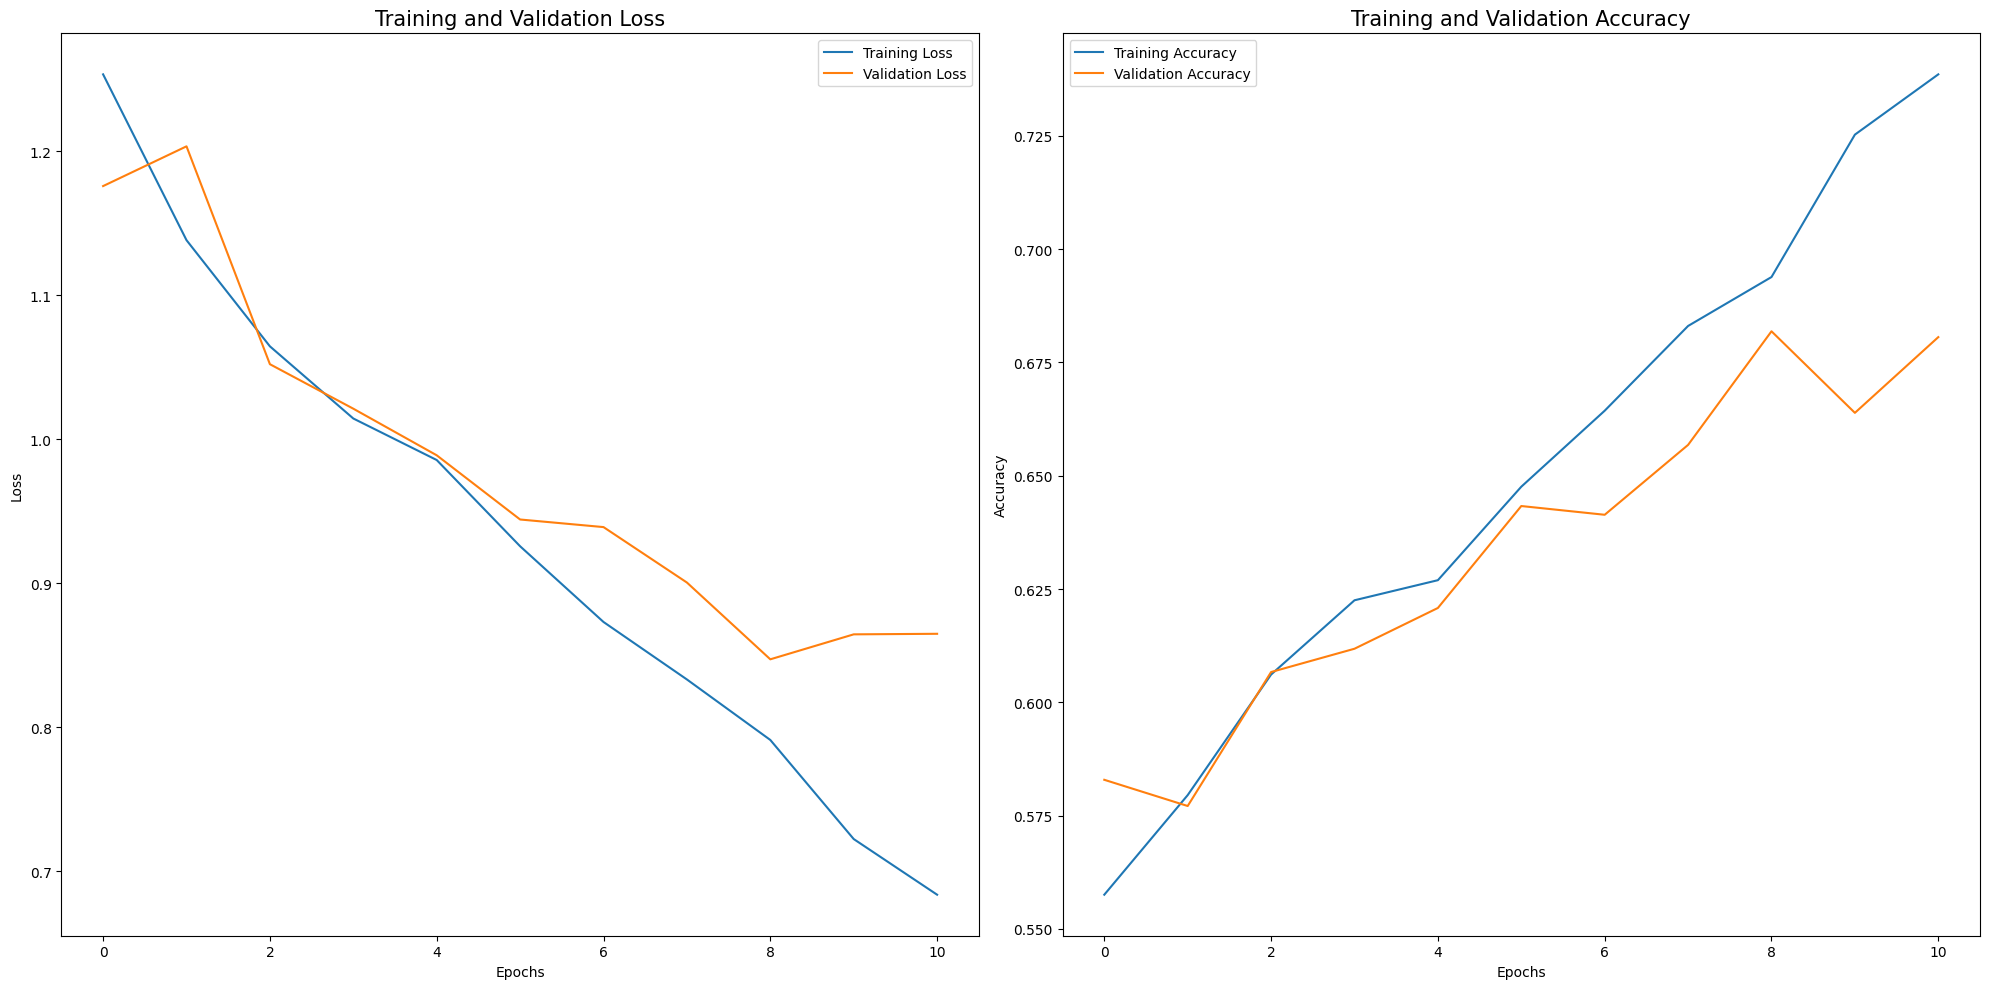

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
    accuracy      loss  val_accuracy  val_loss
0   0.557548  1.253595      0.582905  1.175979
1   0.579526  1.138401      0.577121  1.203588
2   0.606131  1.064651      0.606684  1.052244
3   0.622518  1.014519      0.611825  1.021334
4   0.626952  0.985675      0.620823  0.988963
5   0.647581  0.925768      0.643316  0.944355
6   0.664353  0.873164      0.641388  0.939080
7   0.683054  0.833232      0.656812  0.900567
8   0.693850  0.791206      0.681877  0.847224
9   0.725275  0.722367      0.663882  0.864570
10  0.738577  0.683703      0.680591  0.864954
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6841 - loss: 0.8526
Test Accuracy = 0.6776611804962158
Classification Report
              precision    recall  f1-score   support

           0       0.45      0.17      0.24        30
           1       0.36      0.72      0.48        46
           2       0.51      0.49      0.50        99
           3       0.00      0.00      0.00     

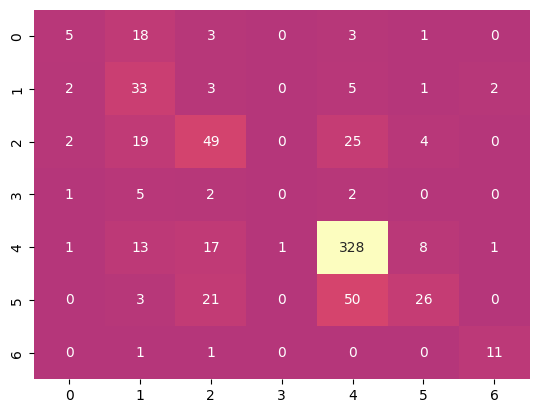

In [14]:
history=pd.DataFrame(hist.history)
# Create figure for training and validation loss and accuracy
plt.figure(figsize=(20, 10))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=15)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=15)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

#prediction test data
predictions = model.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)

#confusion matrix
CM = confusion_matrix(y_test_,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='magma')

print(history)

# test loss and test accuracy
a,b= model.evaluate(X_test,y_test)
print('Test Accuracy =', b)


#classification report
ClassificationReport = classification_report(y_test_,y_pred)
print("Classification Report")
print(ClassificationReport)

## Model 3 ResNet50 Training 

In [9]:
model = ResNet50(
    include_top=True,
    weights=None,  # Set to 'imagenet' if using pre-trained weights
    classes=7,
    input_shape=(176, 176, 3)
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()
#Train model
hist=model.fit(X_train,y_train, epochs=3, validation_data=(X_val,y_val))


Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 176, 176,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 182, 182,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 88, 88,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 88, 88,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 88, 88,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 90, 90,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 44, 44,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 44, 44,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 44, 44,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 44, 44,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 44, 44,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 44, 44,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 44, 44,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 44, 44,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 44, 44,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 44, 44,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 44, 44,    │      1,024 │ conv2_block1_3_c

 Total params: 23,602,055 (90.03 MB)

 Trainable params: 23,548,935 (89.83 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.5457 - loss: 1.7548 - val_accuracy: 0.0694 - val_loss: 4.1616
Epoch 2/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.5887 - loss: 1.1592 - val_accuracy: 0.3972 - val_loss: 1.6020
Epoch 3/3
163/163 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.5904 - loss: 1.1566 - val_accuracy: 0.5752 - val_loss: 1.4324


## Evaluation of model 3

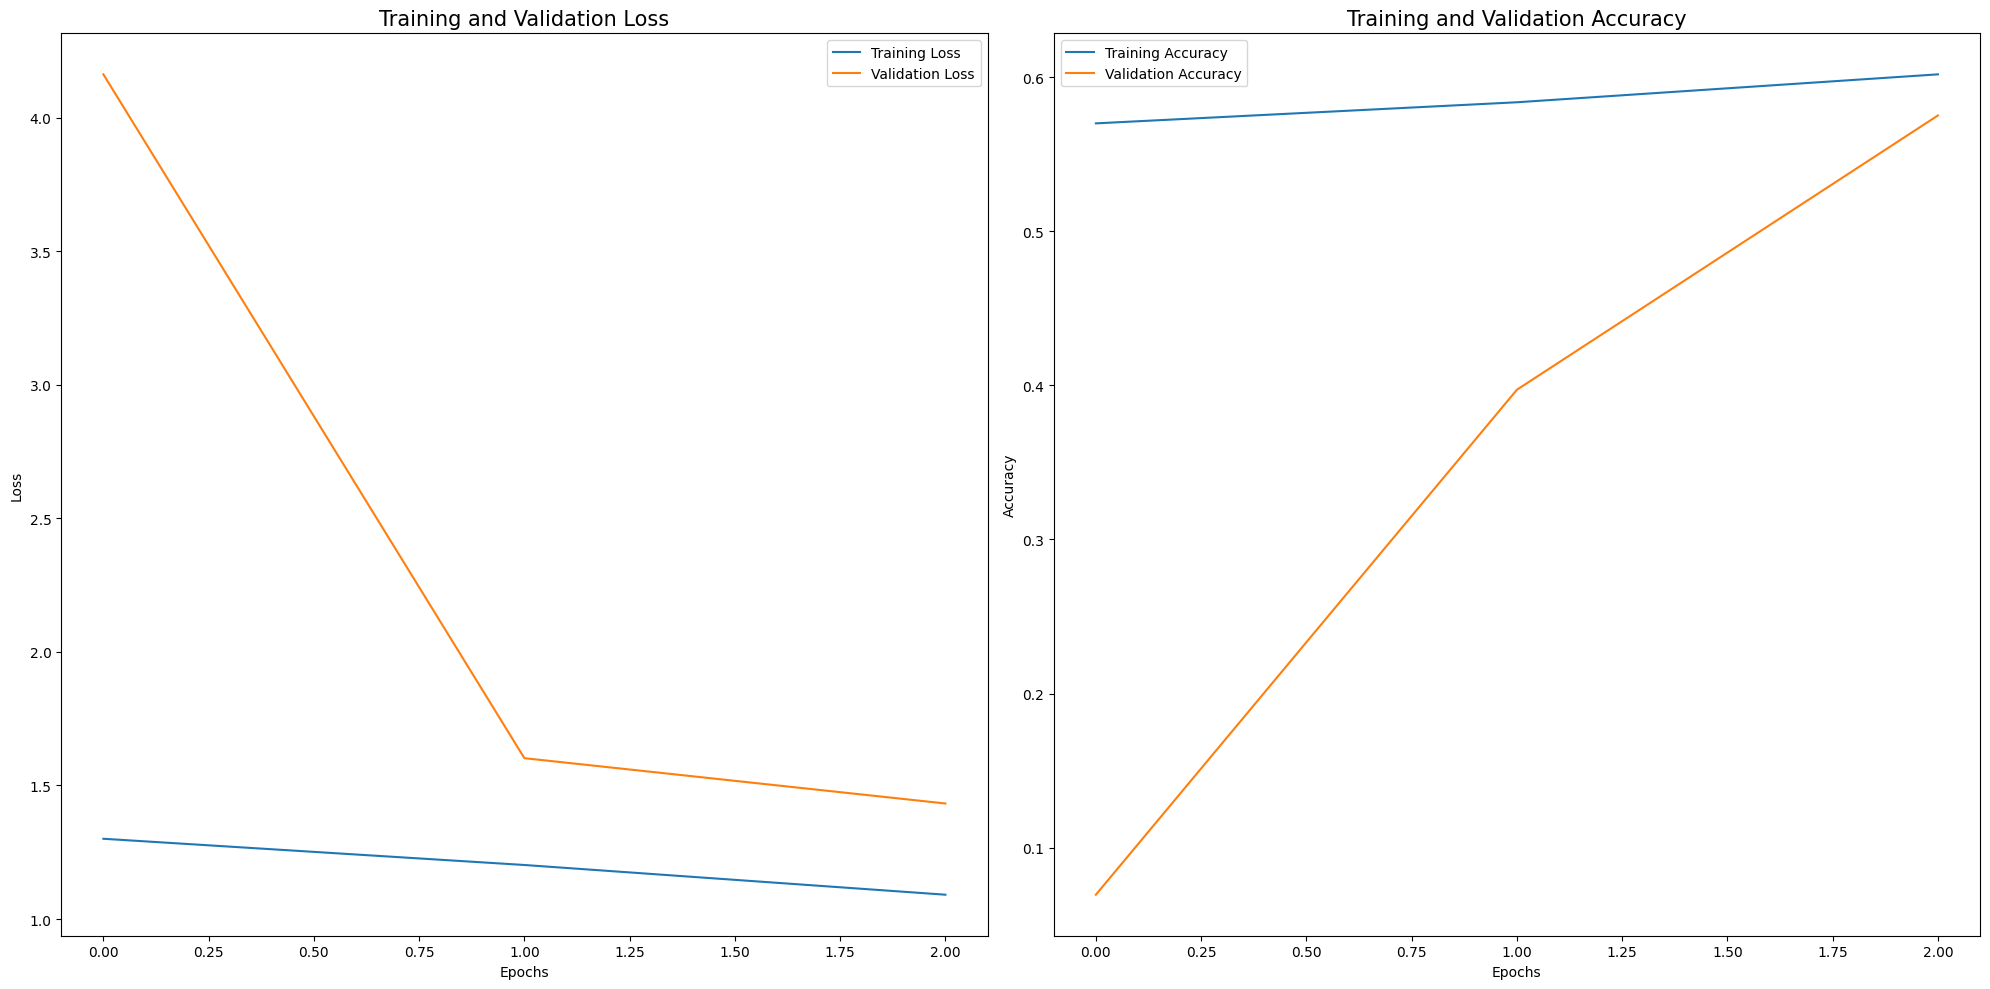

21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 505ms/step
   accuracy      loss  val_accuracy  val_loss
0  0.570079  1.300403      0.069409  4.161565
1  0.583767  1.202220      0.397172  1.602010
2  0.601889  1.091007      0.575193  1.432415
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 473ms/step - accuracy: 0.5708 - loss: 1.4352
Test Accuracy = 0.5787106156349182
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.00      0.00      0.00        46
           2       0.45      0.27      0.34        99
           3       0.00      0.00      0.00        10
           4       0.59      0.97      0.73       369
           5       0.67      0.02      0.04       100
           6       0.00      0.00      0.00        13

    accuracy                           0.58       667
   macro avg       0.24      0.18      0.16       667
weighted avg       0.49      0.58      0.46       667



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

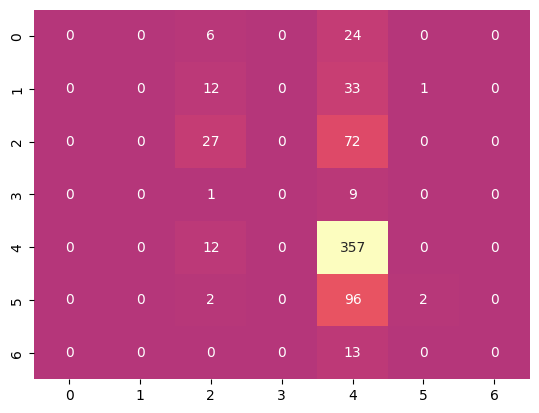

In [10]:
history=pd.DataFrame(hist.history)
# Create figure for training and validation loss and accuracy
plt.figure(figsize=(20, 10))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss', fontsize=15)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy', fontsize=15)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

#prediction test data
predictions = model.predict(X_test)
y_pred = np.argmax(predictions,axis=1)
y_test_ = np.argmax(y_test,axis=1)

#confusion matrix
CM = confusion_matrix(y_test_,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='magma')

print(history)

# test loss and test accuracy
a,b= model.evaluate(X_test,y_test)
print('Test Accuracy =', b)


#classification report
ClassificationReport = classification_report(y_test_,y_pred)
print("Classification Report")
print(ClassificationReport)